In [1]:
!pip install scikit-fuzzy

In [2]:
!pip install scikit-optimize

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import shap
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from copy import deepcopy
from itertools import product
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import tensorflow as tf
from sklearn.linear_model import LogisticRegression

## Data loading

In [6]:
df = pd.read_csv('data_MoodMon_project.csv')

In [7]:
df.head()

id    row_date  patient_number  cgi  \
0  09f84f52-b0f4-4e83-8655-142f8e2878f4  2022-03-21            1081  NaN   
1  e94ac921-991e-4c3f-822b-e30354ba92ff  2022-08-05            1082  NaN   
2  4b6248e5-223c-408a-bad3-c2e1cb39d1ab  2022-09-08            1082  NaN   
3  8cb56544-4725-4712-908e-1c7266bda036  2022-11-23            1082  NaN   
4  958d55f4-26e2-4b51-b600-acde4dae2882  2023-01-17            1082  NaN   

  alarm_date  alarm_cgi  alarm_assess  localjitter  localshimmer  energy_mean  \
0        NaN        NaN           NaN     0.014363      0.073988     0.000561   
1        NaN        NaN           NaN          NaN           NaN          NaN   
2        NaN        NaN           NaN          NaN           NaN          NaN   
3        NaN        NaN           NaN          NaN           NaN          NaN   
4        NaN        NaN           NaN          NaN           NaN          NaN   

   energy_std  f0_slope_mean  f0_slope_std  pitch_mean  pitch_std  \
0    0.001034      -0.218806      0.845738   186.11009  47.877323   
1         NaN            NaN           NaN         NaN        NaN   
2         NaN            NaN           NaN         NaN        NaN   
3         NaN            NaN           NaN         NaN        NaN   
4         NaN            NaN           NaN         NaN        NaN   

   long_pauses  brief_pauses  sleep_length  tel_usages_time  
0          1.0           1.0         320.0              NaN  
1          NaN           NaN           NaN              NaN  
2          NaN           NaN           NaN              NaN  
3          NaN           NaN           NaN              NaN  
4          NaN           NaN           NaN              NaN

## Exploratory analysis

In [8]:
df['state'] = np.where(df['cgi'].notna(), df['cgi'],
                       np.where(df['alarm_cgi'].notna(), df['alarm_cgi'], np.nan))
filtered_df = df.dropna(subset=['state'])
filtered_df = filtered_df[filtered_df['state'].isin([3,4,5,6])]
filtered_df['state'] = filtered_df['state'].apply(lambda x: 0 if x == 3 else 1)
X = filtered_df.drop(['state', 'patient_number'], axis=1)
y = filtered_df['state']

X = X.drop(['id', 'alarm_assess', 'row_date', 'alarm_date', 'cgi', 'alarm_cgi', 'tel_usages_time'], axis=1)

non_nan_values = ~X.isna().any(axis=1)
X = X[non_nan_values]
y = y[non_nan_values]

In [9]:
X.head()

localjitter  localshimmer  energy_mean  energy_std  f0_slope_mean  \
17     0.043528      0.177301     0.000333    0.000611      -0.022299   
29     0.033351      0.098912     0.004739    0.009071      -0.166415   
41     0.017913      0.084511     0.010492    0.021070      -0.147620   
42     0.011965      0.071378     0.001112    0.002188      -0.110841   
43     0.014180      0.062700     0.001700    0.002661      -0.164887   

    f0_slope_std  pitch_mean  pitch_std  long_pauses  brief_pauses  \
17      1.234111   135.70312  55.120110          1.0           1.0   
29      1.519666   107.71072  35.030150          1.0           4.0   
41      0.823015   199.95842  48.286690          4.0          20.0   
42      1.168939   161.61990  46.535503          1.0           1.0   
43      0.778435   197.02481  32.381207          1.0           1.0   

    sleep_length  
17         191.0  
29         540.0  
41         510.0  
42         517.0  
43         700.0

In [10]:
X.describe()

localjitter  localshimmer  energy_mean   energy_std  f0_slope_mean  \
count  2382.000000   2382.000000  2382.000000  2382.000000    2382.000000   
mean      0.024518      0.102916     0.027337     0.018441      -0.124202   
std       0.008849      0.028111     0.296260     0.105645       0.072967   
min       0.008558      0.042683     0.000025     0.000034      -0.539302   
25%       0.018774      0.082943     0.001201     0.002377      -0.162535   
50%       0.022481      0.098549     0.003441     0.006756      -0.116903   
75%       0.027500      0.117730     0.008657     0.015095      -0.075299   
max       0.091685      0.232977     5.000323     2.492838       0.150153   

       f0_slope_std   pitch_mean    pitch_std  long_pauses  brief_pauses  \
count   2382.000000  2382.000000  2382.000000  2382.000000   2382.000000   
mean       1.058825   160.635247    47.909474     3.894207     13.778338   
std        0.235265    34.570807    20.687849     9.803601     32.914618   
min        0.572277    80.083000     2.036860     1.000000      1.000000   
25%        0.857981   131.083517    33.322173     1.000000      1.000000   
50%        1.001921   163.050315    46.534874     1.000000      2.000000   
75%        1.245308   188.543608    60.268088     2.000000     10.000000   
max        1.776452   343.574160   145.299580   135.000000    430.000000   

       sleep_length  
count   2382.000000  
mean     424.078505  
std      173.326643  
min        0.000000  
25%      370.000000  
50%      451.000000  
75%      522.000000  
max     1392.000000

In [11]:
X.isna().sum()

localjitter      0
localshimmer     0
energy_mean      0
energy_std       0
f0_slope_mean    0
f0_slope_std     0
pitch_mean       0
pitch_std        0
long_pauses      0
brief_pauses     0
sleep_length     0
dtype: int64

### Outliers

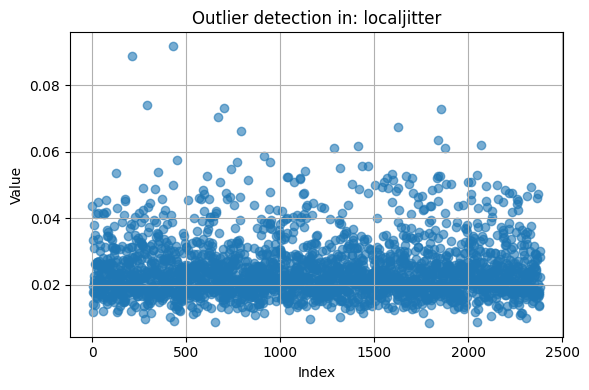

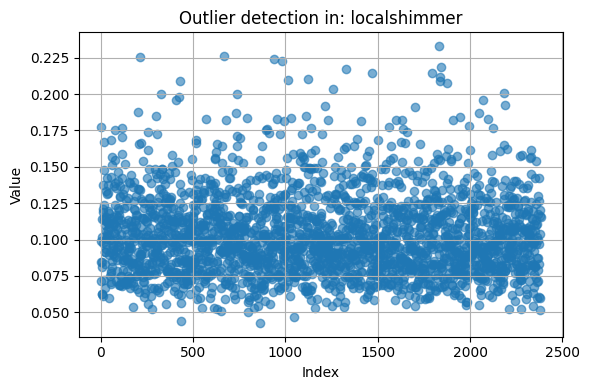

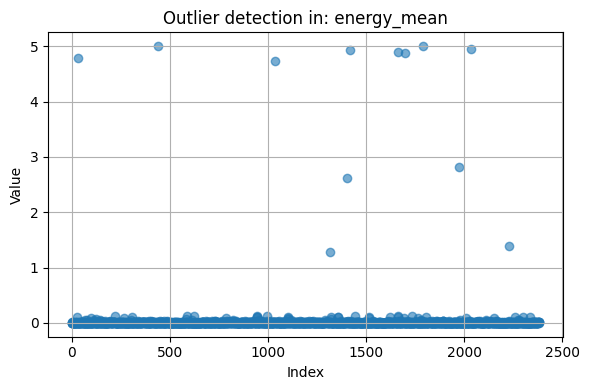

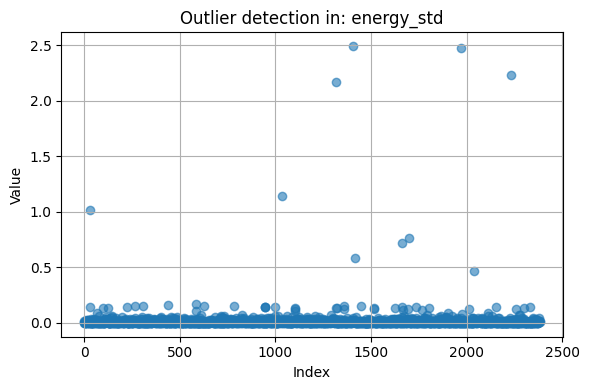

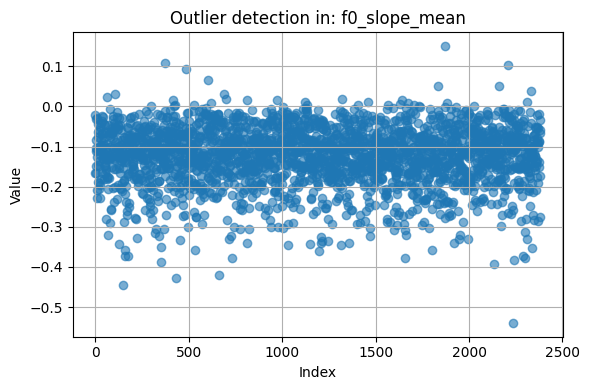

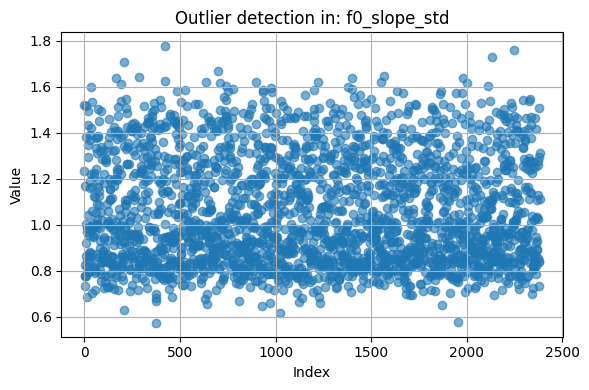

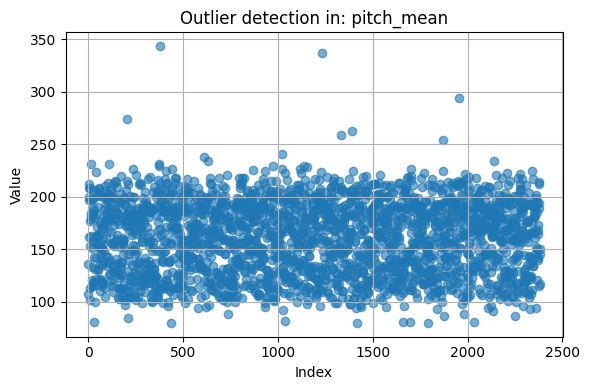

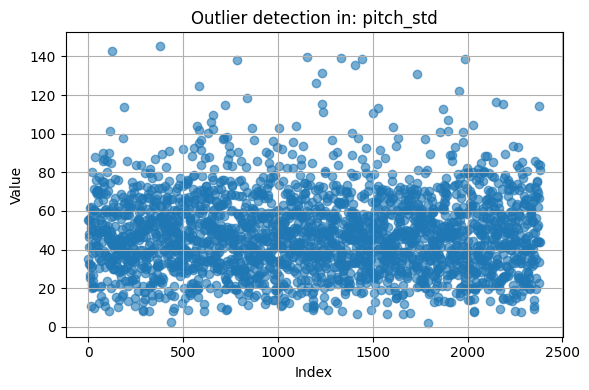

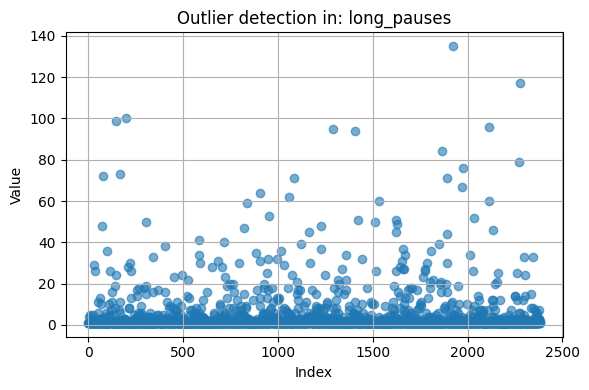

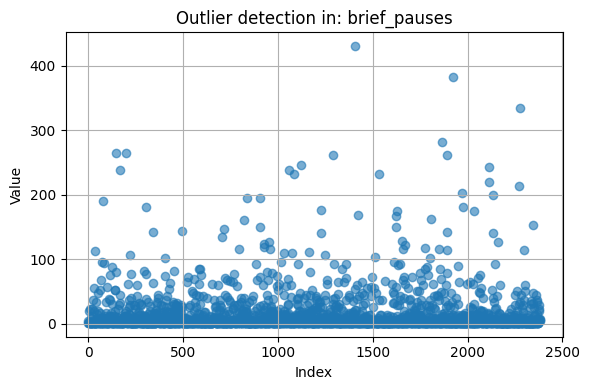

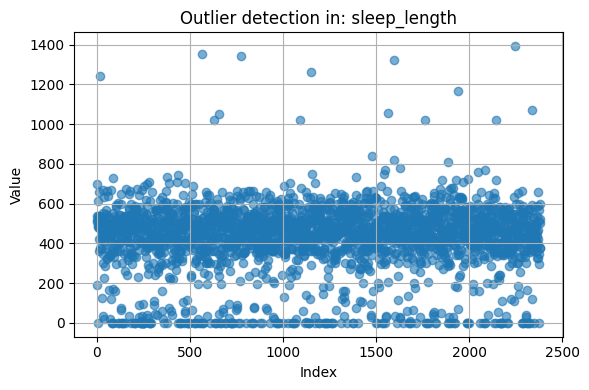

In [12]:
for col in X.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(range(len(X[col])), X[col], alpha=0.6)
    plt.title(f'Outlier detection in: {col}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# Columns with values equal 0
a = np.zeros(len(X.columns))
for i in range(len(X.columns)):
  a[i]=sum(X.iloc[:,i]==0)
[val for val in a]
data = {'column name': X.columns,
        'number of zeros': [val for val in a]}
pd.DataFrame(data).head(30)

column name  number of zeros
0     localjitter              0.0
1    localshimmer              0.0
2     energy_mean              0.0
3      energy_std              0.0
4   f0_slope_mean              0.0
5    f0_slope_std              0.0
6      pitch_mean              0.0
7       pitch_std              0.0
8     long_pauses              0.0
9    brief_pauses              0.0
10   sleep_length            145.0

In [14]:
X['localjitter'].sort_values(ascending=False).head(10)

3310     0.091685
1688     0.088687
2267     0.074098
5670     0.073029
15401    0.072960
5276     0.070506
13615    0.067313
6384     0.066189
15313    0.063525
17226    0.062027
Name: localjitter, dtype: float64

In [15]:
# Tworzymy funkcję, do problemu z outlierami. Jak widać na wykresach, miały one różny charakter, więc metody są różne dla różnych kolumn.

def clean_raw_data(X):

    X_replaced = X.copy()

    # Sleep length: błędy pomiarowe (zbyt krótki lub zbyt długi sen)
    mask_sleep = (X_replaced['sleep_length'] < 30) | (X_replaced['sleep_length'] > 1200)
    sleep_median = X_replaced.loc[~mask_sleep, 'sleep_length'].median()
    X_replaced.loc[mask_sleep, 'sleep_length'] = sleep_median

    # Pitch: nieprawdopodobnie wysokie wartości (np. >1000 Hz)
    X_replaced['pitch_mean'] = X_replaced['pitch_mean'].clip(upper=1000)

    # Brief pauses
    brief_max = X['brief_pauses'].quantile(0.999)
    X_replaced['brief_pauses'] = X_replaced['brief_pauses'].clip(upper=brief_max)

    # Long pauses: podobnie
    long_max = X['long_pauses'].quantile(0.999)
    X_replaced['long_pauses'] = X_replaced['long_pauses'].clip(upper=long_max)

    return X_replaced

In [16]:
X_replaced = clean_raw_data(X)

In [17]:
replaced_mask = (X != X_replaced) & ~(X.isna() & X_replaced.isna())

In [18]:
# Count rows with at least one changed value
rows_with_replacements = replaced_mask.any(axis=1)
num_rows_changed = rows_with_replacements.sum()
print(f"Number of rows with at least one outlier replaced: {num_rows_changed}")

Number of rows with at least one outlier replaced: 171


In [19]:
X_replaced

localjitter  localshimmer  energy_mean  energy_std  f0_slope_mean  \
17        0.043528      0.177301     0.000333    0.000611      -0.022299   
29        0.033351      0.098912     0.004739    0.009071      -0.166415   
41        0.017913      0.084511     0.010492    0.021070      -0.147620   
42        0.011965      0.071378     0.001112    0.002188      -0.110841   
43        0.014180      0.062700     0.001700    0.002661      -0.164887   
...            ...           ...          ...         ...            ...   
19988     0.016915      0.060134     0.009405    0.011545      -0.172098   
19995     0.022492      0.103862     0.018294    0.039930      -0.276247   
19996     0.030025      0.120578     0.007405    0.013016      -0.059382   
19998     0.019340      0.116256     0.004030    0.011616      -0.034598   
19999     0.028234      0.115302     0.010676    0.017770      -0.067282   

       f0_slope_std  pitch_mean  pitch_std  long_pauses  brief_pauses  \
17         1.234111  135.703120  55.120110          1.0           1.0   
29         1.519666  107.710720  35.030150          1.0           4.0   
41         0.823015  199.958420  48.286690          4.0          20.0   
42         1.168939  161.619900  46.535503          1.0           1.0   
43         0.778435  197.024810  32.381207          1.0           1.0   
...             ...         ...        ...          ...           ...   
19988      0.841008  189.260480  22.525116          1.0           5.0   
19995      1.508087  115.090500  66.693146          7.0          20.0   
19996      1.293792  145.285520  83.781780          1.0           5.0   
19998      1.111028  117.357056  44.105553          1.0           4.0   
19999      1.311964  150.645970  80.955696          2.0           7.0   

       sleep_length  
17            191.0  
29            540.0  
41            510.0  
42            517.0  
43            700.0  
...             ...  
19988         378.0  
19995         600.0  
19996         525.0  
19998         375.0  
19999         500.0  

[2382 rows x 11 columns]

In [20]:
X_fuzzy = pd.concat([X_replaced, y], axis = 1).reset_index(drop=True, inplace=False)

# 1)

## Calculating memberships

In [84]:
def membership_function(data, var_name, value, central=0, spread=0.1, plot=True, na_omit=False,
           expert = False,use_central_and_spread=False):
    d = deepcopy(data)

    if na_omit:
        d = d.loc[~d[var_name].isna()]
    else:
        d = d.fillna(0)

    d = d[var_name]

    max_for_universe = np.max(d)
    min_for_universe = np.min(d)

    if np.isclose(min_for_universe, max_for_universe):
        # If all values are the same, treat as 'medium'
        if isinstance(value, pd.Series):
            low_membership = pd.Series(0.0, index=value.index)
            medium_membership = pd.Series(1.0, index=value.index)
            high_membership = pd.Series(0.0, index=value.index)
        else:
             low_membership = 0.0
             medium_membership = 1.0
             high_membership = 0.0

        return (low_membership, medium_membership, high_membership)

    universe = np.arange(min_for_universe, max_for_universe, 0.001)

    reg_name = var_name

    reg = ctrl.Consequent(universe, reg_name)

    if use_central_and_spread:
        first_quartile = np.max([0,min_for_universe])
        median_quartile = 0.1
        third_quartile = np.min([0.2,max_for_universe])
    else:
        first_quartile = np.percentile(d, 25)
        median_quartile = np.percentile(d, 50)
        third_quartile = np.percentile(d, 75)

    low = fuzz.trapmf(reg.universe, [min_for_universe, min_for_universe, first_quartile, third_quartile])
    medium = fuzz.trimf(reg.universe, [first_quartile, median_quartile, third_quartile])
    high = fuzz.trapmf(reg.universe, [first_quartile, third_quartile, max_for_universe, max_for_universe])

    if plot:
        fig, (ax0) = plt.subplots(nrows=1, figsize=(3, 3))
        ax0.plot(universe, low, 'b', linewidth=2, label='low')
        ax0.plot(universe, medium, 'r', linewidth=2, label='medium')
        ax0.plot(universe, high, 'g', linewidth=2, label='high')
        ax0.set_title(str(var_name))
        ax0.legend()
        plt.tight_layout()
        plt.savefig(f'{var_name}.png')
        plt.close()

    return (fuzz.interp_membership(universe, low, value),
            fuzz.interp_membership(universe, medium, value),
            fuzz.interp_membership(universe, high, value)
            )

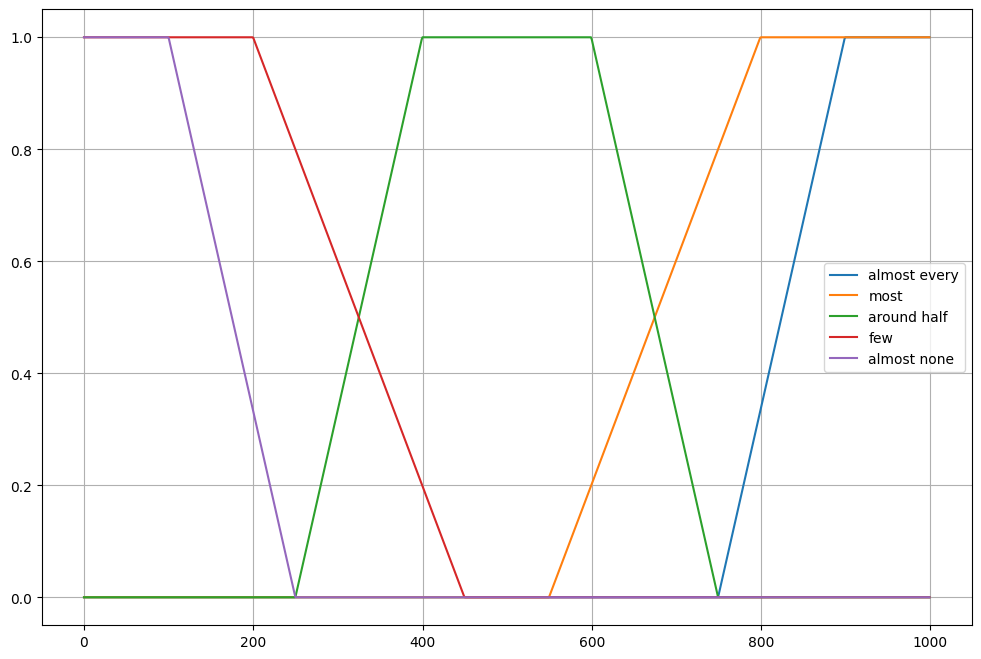

In [85]:
def words(word):
  x = np.linspace(0, 1, 1000)
  if word=='almost every':
    return(fuzz.trapmf(x, [0.75, 0.9, 1, 1]))
  if word=='most':
    return(fuzz.trapmf(x, [0.55, 0.8, 1, 1]))
  if word=='around half':
    return(fuzz.trapmf(x, [0.25, 0.4, 0.6, 0.75]))
  if word=='few':
    return(fuzz.trapmf(x, [0, 0, 0.2, 0.45]))
  if word=='almost none':
    return(fuzz.trapmf(x, [0, 0, 0.1, 0.25]))

plt.figure(figsize=(12,8))
plt.plot(words('almost every'),label='almost every')
plt.plot(words('most'),label='most')
plt.plot(words('around half'),label='around half')
plt.plot(words('few'),label='few')
plt.plot(words('almost none'),label='almost none')
plt.legend(loc ="center right")
plt.grid()
plt.show()

In [86]:
def membership(fuzzy_number, value, dataframe):
  d=deepcopy(dataframe)
  max_for_universe = 1
  min_for_universe = 0
  universe = np.arange(min_for_universe, max_for_universe,0.001)
  return(fuzz.interp_membership(universe, fuzzy_number, value))

## Function to generate descriptive linguistic summaries

In [87]:
def generate_descriptive_linguistic_summaries(dataframe, words1, var_level1, var_level2, states, norms):

    for var in list(set(var_level1 + var_level2)):
        ling = membership_function(dataframe, var,dataframe.loc[0:,var], central=0, spread=0.1, plot=True, na_omit=False,
                  expert = False,use_central_and_spread=False)

        ling_df = pd.DataFrame({f'low {var}': ling[0], f'medium {var}': ling[1], f'high {var}': ling[2]})

        ling_df.reset_index(drop=True, inplace=True)
        dataframe = pd.concat([dataframe, ling_df], axis=1)

    vars1 = []
    vars2 = []

    for var in var_level1:
        vars1.append(f'low {var}')
        vars1.append(f'medium {var}')
        vars1.append(f'high {var}')

    for var in var_level2:
        vars2.append(f'low {var}')
        vars2.append(f'medium {var}')
        vars2.append(f'high {var}')

    combinations = list(product(vars1, states, vars2, words1, norms))

    output = []
    for combination in combinations:
        var1, state, var2, word, norm = combination
        if var1 == var2:
            continue

        d = deepcopy(dataframe)

        result_df = pd.DataFrame(columns=['Descr', 'Degree of Truth'])
        if word == 'almost every':
            word1 = words('almost every')
        elif word == 'most':
            word1 = words('most')
        elif word == 'around half':
            word1 = words('around half')
        elif word == 'few':
            word1 = words('few')
        elif word == 'almost none':
            word1 = words('almost none')

        if state != 'all':
            d = d[d['state'] == state]

        if norm == 'min':
            mins = pd.concat([d[var1], d[var2]], axis=1).min(axis=1)
        elif norm == 'product':
            mins = pd.concat([d[var1], d[var2]], axis=1).apply(np.prod, axis=1)
        elif norm == 't_norm':
            mins = pd.concat([d[var1], d[var2]], axis=1).apply(lambda row: np.fmin(row[var1], row[var2]), axis=1)

        degree_of_truth = membership(word1, (np.sum(mins)) / (np.sum(d[var1])), d[var1])
        degree_of_support =   sum(mins>0) /len(d[var1])
        degree_of_focus = sum(d[var2]) / len(d[var2])

        if state=='all':
          tresc = f'For {word} patients with {var1} we have {var2}'
        elif state==0:
          tresc = f'For {word} patients in euthymia with {var1} we have {var2}'
        elif state==1:
          tresc = f'For {word} patients in depression with {var1} we have {var2}'

        result_df = pd.concat([result_df, pd.DataFrame({'Descr': [tresc],
                                      'Degree of Truth': [degree_of_truth]})])

        output.append(result_df)

    result_ls = pd.concat(output, ignore_index=True)

    return result_ls

## Generations of summaries

In [88]:
words1 = ["almost every", "most", "around half", "few", "almost none"]
variables = ["energy_mean", "f0_slope_mean", "localjitter", "localshimmer", "pitch_mean"]
states = [0, 1, "all"]
norm = ["t_norm"]

In [89]:
results_ls2 = generate_descriptive_linguistic_summaries(X_fuzzy, words1, variables, variables, states, norm)

C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\3249777822.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Descr': [tresc],
C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\3249777822.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Descr': [tresc],
C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\3249777822.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA en

## All possible LSs

In [90]:
results_ls2

Descr  Degree of Truth
0     For almost every patients in euthymia with low...         0.000000
1     For most patients in euthymia with low energy_...         0.000000
2     For around half patients in euthymia with low ...         1.000000
3     For few patients in euthymia with low energy_m...         0.073131
4     For almost none patients in euthymia with low ...         0.000000
...                                                 ...              ...
3145  For almost every patients with high pitch_mean...         0.000000
3146  For most patients with high pitch_mean we have...         0.000000
3147  For around half patients with high pitch_mean ...         0.575722
3148  For few patients with high pitch_mean we have ...         0.454567
3149  For almost none patients with high pitch_mean ...         0.000000

[3150 rows x 2 columns]

In [91]:
results_ls2.sort_values(by = 'Degree of Truth', ascending = False).head(10)

Descr  Degree of Truth
1527  For around half patients in euthymia with medi...              1.0
1387  For around half patients in depression with lo...              1.0
2277  For around half patients with medium localshim...              1.0
2907  For around half patients with medium pitch_mea...              1.0
782   For around half patients with low f0_slope_mea...              1.0
192   For around half patients with low energy_mean ...              1.0
3022  For around half patients in depression with hi...              1.0
1371  For most patients in depression with low local...              1.0
197   For around half patients with low energy_mean ...              1.0
772   For around half patients with low f0_slope_mea...              1.0

# 2)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_replaced, y, test_size=0.4, random_state=123)

## XGBoost Model

In [55]:
#Train the XGBoost model
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 2,
}
search_spaces = {
    'booster': Categorical(['gbtree', 'gblinear', 'dart']),
    'eta': Real(1e-10, 1, prior='log-uniform'),
    'n_estimators': Integer(1, 500),
    'max_depth': Integer(1, 10),
    'subsample': Real(0.1, 1, prior='uniform'),
    'colsample_bytree': Real(0, 1, prior='uniform'),
    'colsample_bylevel': Real(0, 1, prior='uniform'),
    'lambda': Real(1e-5, 1e+2, prior='log-uniform'),
    'alpha': Real(1e-5, 1e+2, prior='log-uniform'),
    'min_child_weight': Real(1, 1e+7, prior='log-uniform')
}
xgb = XGBClassifier(**xgb_params)
xgb_model = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=123,
    scoring='roc_auc'
)
xgb_model.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'lambda': Real(low=1e-05, high=100.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Real(low=1, high=10000000.0, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1, prior='uniform', transform='normalize')})

In [56]:
y_pred = xgb_model.predict(X_test)
xgb_cm = confusion_matrix(y_test, y_pred[:,1], labels=xgb_model.classes_)
xgb_cr = classification_report(y_test, y_pred[:,1])

print(xgb_cm)
print(xgb_cr)

[[157 210]
 [ 92 494]]
              precision    recall  f1-score   support

           0       0.63      0.43      0.51       367
           1       0.70      0.84      0.77       586

    accuracy                           0.68       953
   macro avg       0.67      0.64      0.64       953
weighted avg       0.67      0.68      0.67       953



### SHAP

In [57]:
# SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model.best_estimator_)

# Compute SHAP values for all classes
shap_values = explainer.shap_values(X_test)

print(shap_values)

[[[ 2.29313137e-05  1.99593278e-03]
  [-3.69234085e-02  3.40642780e-02]
  [ 3.53686232e-03 -2.01217015e-03]
  ...
  [-8.19862471e-05  1.54543712e-04]
  [-5.51400241e-03  7.02179829e-03]
  [ 2.71413079e-03 -2.26474553e-03]]

 [[ 1.67032573e-02 -1.68212894e-02]
  [ 4.28535268e-02 -3.89104299e-02]
  [ 5.89830754e-03 -3.21488408e-03]
  ...
  [ 1.73937995e-03 -2.34378385e-03]
  [ 1.29055441e-03 -2.81923823e-03]
  [ 4.65696398e-03 -4.30115405e-03]]

 [[-1.32008980e-03  7.23399746e-04]
  [ 3.79281491e-02 -3.28614302e-02]
  [ 1.33486418e-03 -6.00784479e-05]
  ...
  [ 9.69764194e-04 -1.39636348e-03]
  [-2.74017127e-03  3.95835564e-03]
  [-9.30527877e-03  9.63348057e-03]]

 ...

 [[-4.85914014e-03  2.95236544e-03]
  [-2.25762092e-02  2.32762974e-02]
  [-2.51607783e-02  2.60103829e-02]
  ...
  [-1.74698172e-04 -2.27334705e-04]
  [-4.78849700e-03  7.18266144e-03]
  [-7.31008314e-03  9.36178118e-03]]

 [[ 2.88332673e-03 -5.68942283e-04]
  [-6.38633734e-03  5.06943511e-03]
  [-1.36710024e-02  1.3346

C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\2555049358.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,class_id], X_test, feature_names=feature_names,


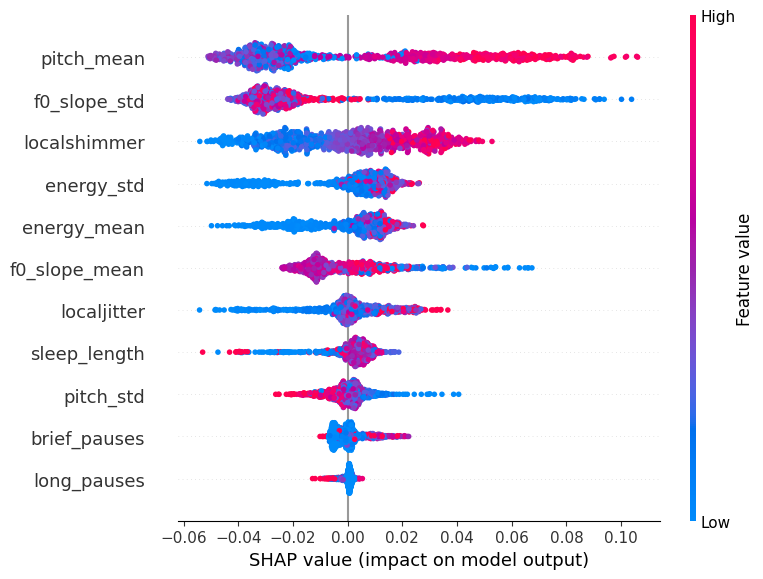

C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\2555049358.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,class_id], X_test, feature_names=feature_names,


<Figure size 640x480 with 0 Axes>

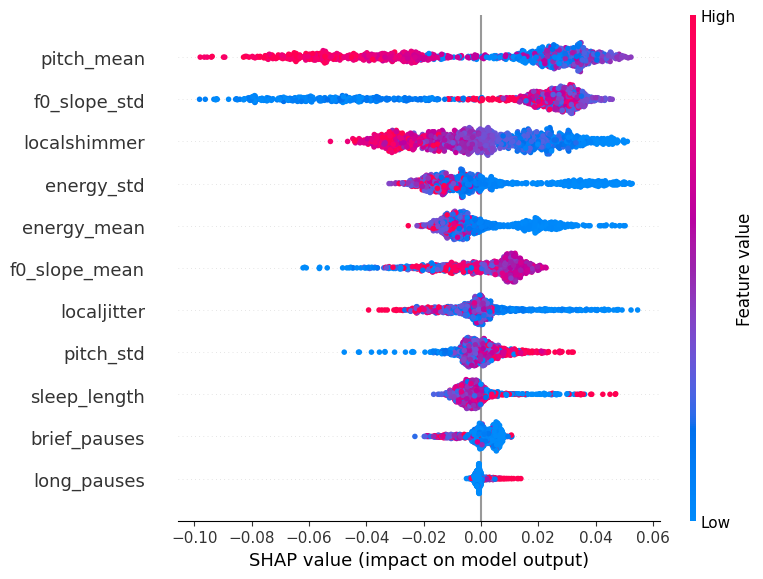

<Figure size 640x480 with 0 Axes>

In [58]:
# Create beeswarm plots for each class
for class_id in range(shap_values.shape[2]):
    plt.figure()
    shap.summary_plot(shap_values[:,:,class_id], X_test, feature_names=feature_names,
                      class_names=['euthymia', 'depression'], show=True)
    figname = f"shap_beeswarm_class_{class_id}.png"
    plt.clf()

## Elastic Net Model

In [47]:
feature_names=X_test.columns

In [48]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.values)
X_train_scaled = scaler.transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

In [49]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [51]:
#Train the Elastic Net model

search_spaces = {
    'penalty': Categorical(['elasticnet']),
    'solver': Categorical(['saga']),
    'C': Real(1e-10, 1e+10, prior='log-uniform'),
    'l1_ratio': Real(0, 1, prior='uniform')
}

log = LogisticRegression()
log_model = BayesSearchCV(
    estimator=log,
    search_spaces=search_spaces,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=123,
    scoring='roc_auc'
)
log_model.fit(X_train_scaled, y_train)

C:\Users\XXX\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


BayesSearchCV(cv=3, estimator=LogisticRegression(), n_iter=32, n_jobs=-1,
              random_state=123, scoring='roc_auc',
              search_spaces={'C': Real(low=1e-10, high=10000000000.0, prior='log-uniform', transform='normalize'),
                             'l1_ratio': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'penalty': Categorical(categories=('elasticnet',), prior=None),
                             'solver': Categorical(categories=('saga',), prior=None)})

In [52]:
y_pred = log_model.predict(X_test_scaled)
log_cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)
log_cr = classification_report(y_test, y_pred)

print(log_cm)
print(log_cr)

[[130 237]
 [ 89 497]]
              precision    recall  f1-score   support

           0       0.59      0.35      0.44       367
           1       0.68      0.85      0.75       586

    accuracy                           0.66       953
   macro avg       0.64      0.60      0.60       953
weighted avg       0.64      0.66      0.63       953



### SHAP

In [53]:
# SHAP explainer for the XGBoost model
explainer = shap.Explainer(log_model.best_estimator_.predict_proba, X_test_scaled)

# Compute SHAP values for all classes
shap_values = explainer.shap_values(X_test_scaled)

print(shap_values)

PermutationExplainer explainer: 954it [00:19, 33.33it/s]                         

[[[-2.21056971e-02  2.21056971e-02]
  [-6.03246180e-02  6.03246180e-02]
  [-5.81802343e-04  5.81802343e-04]
  ...
  [ 1.81808372e-02 -1.81808372e-02]
  [-3.83026783e-02  3.83026783e-02]
  [ 1.21623631e-03 -1.21623631e-03]]

 [[ 1.59367194e-02 -1.59367194e-02]
  [ 9.68454562e-02 -9.68454562e-02]
  [-6.99350136e-04  6.99350136e-04]
  ...
  [ 2.01698146e-02 -2.01698146e-02]
  [-3.42061300e-02  3.42061300e-02]
  [ 2.54315554e-03 -2.54315554e-03]]

 [[ 1.28904597e-02 -1.28904597e-02]
  [ 7.32349293e-02 -7.32349293e-02]
  [-9.51565596e-04  9.51565596e-04]
  ...
  [ 1.82039281e-02 -1.82039281e-02]
  [-3.71225605e-02  3.71225605e-02]
  [ 1.52846931e-02 -1.52846931e-02]]

 ...

 [[-2.86491343e-02  2.86491343e-02]
  [-5.15276098e-02  5.15276098e-02]
  [-1.33419994e-03  1.33419994e-03]
  ...
  [ 1.84223737e-02 -1.84223737e-02]
  [-4.19553346e-02  4.19553346e-02]
  [ 1.58848381e-02 -1.58848381e-02]]

 [[-1.63998924e-02  1.63998924e-02]
  [-1.66838555e-02  1.66838555e-02]
  [-1.34794936e-03  1.3479

C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\1170203088.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,class_id], X_test_scaled, feature_names=feature_names,


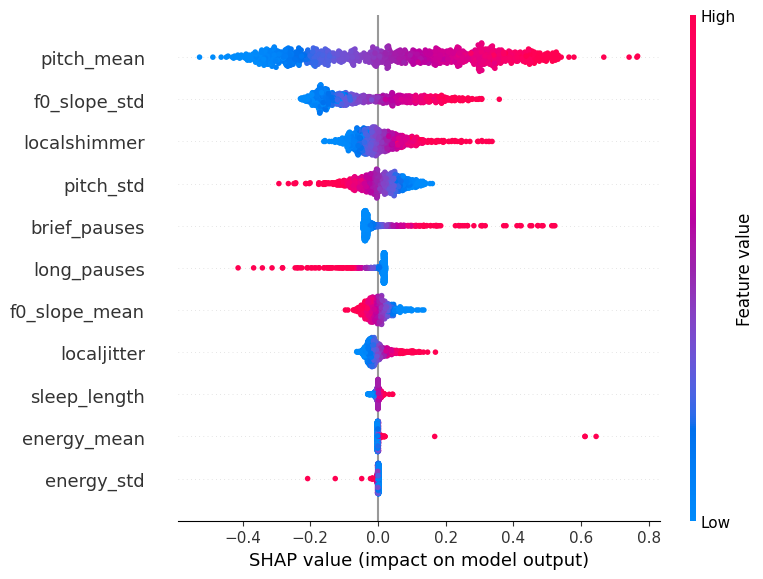

C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\1170203088.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,class_id], X_test_scaled, feature_names=feature_names,


<Figure size 640x480 with 0 Axes>

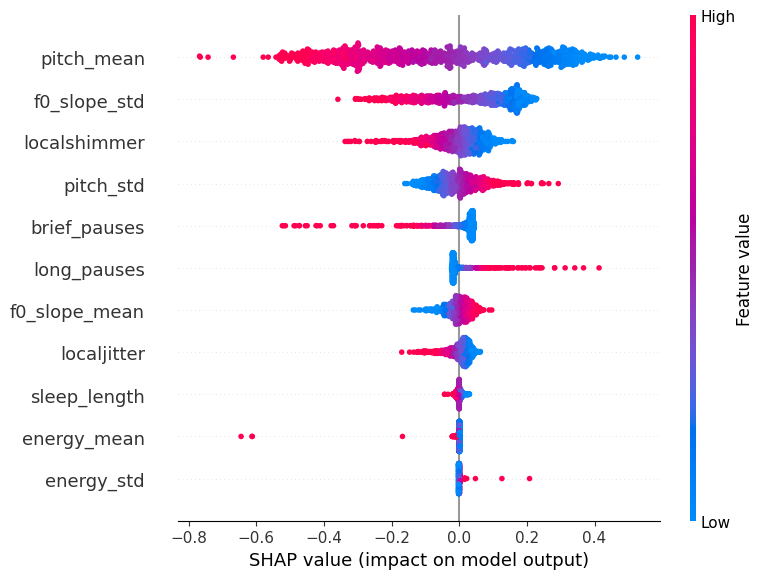

<Figure size 640x480 with 0 Axes>

In [54]:
# Create beeswarm plots for each class
for class_id in range(shap_values.shape[2]):
    plt.figure()
    shap.summary_plot(shap_values[:,:,class_id], X_test_scaled, feature_names=feature_names,
                      class_names=['euthymia', 'depression'], show=True)
    figname = f"shap_beeswarm_class_{class_id}.png"
    plt.clf()

## Neural Network

In [40]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', name='dense'),
        tf.keras.layers.Dropout(0.2, name='dropout'),
        tf.keras.layers.Dense(4, activation='softmax', name='output')])
    model.build()
    return model

model_name = "baseline"
baseline = build_model()

baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
baseline.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

baseline.fit(X_train, y_train, epochs=15,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping])

y_pred_states = baseline.predict(X_test)
y_pred_states = np.argmax(y_pred_states, axis=1)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4864 - loss: 1.1830 - val_accuracy: 0.6268 - val_loss: 0.8389
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6313 - loss: 0.8107 - val_accuracy: 0.6604 - val_loss: 0.7169
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6583 - loss: 0.7027 - val_accuracy: 0.6583 - val_loss: 0.6693
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6530 - loss: 0.6673 - val_accuracy: 0.6792 - val_loss: 0.6496
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6339 - loss: 0.6617 - val_accuracy: 0.6792 - val_loss: 0.6399
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6389 - loss: 0.6614 - val_accuracy: 0.6813 - val_loss: 0.6343
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6855 - loss: 0.6202 - val_accuracy: 0.6792 - val_loss: 0.6279
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6585 - loss: 0.6368 - val_accuracy: 0.6834 - val_loss

In [42]:
cm_base = confusion_matrix(y_test, y_pred_states)
cr_base = classification_report(y_test, y_pred_states)

print(cm_base)
print(cr_base)

[[ 79 101]
 [ 43 254]]
              precision    recall  f1-score   support

           0       0.65      0.44      0.52       180
           1       0.72      0.86      0.78       297

    accuracy                           0.70       477
   macro avg       0.68      0.65      0.65       477
weighted avg       0.69      0.70      0.68       477



### SHAP

In [43]:
# prepare data for shap
X_train_summary = shap.sample(X_train, 100)
end = len(X_test)
feature_names=X_test.columns

In [44]:
#calculate shap values
explainer = shap.KernelExplainer(baseline.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
data_shap_base = pd.DataFrame(X_test, columns = feature_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/477 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━

C:\Users\XXX\AppData\Local\Temp\ipykernel_2588\1214242901.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


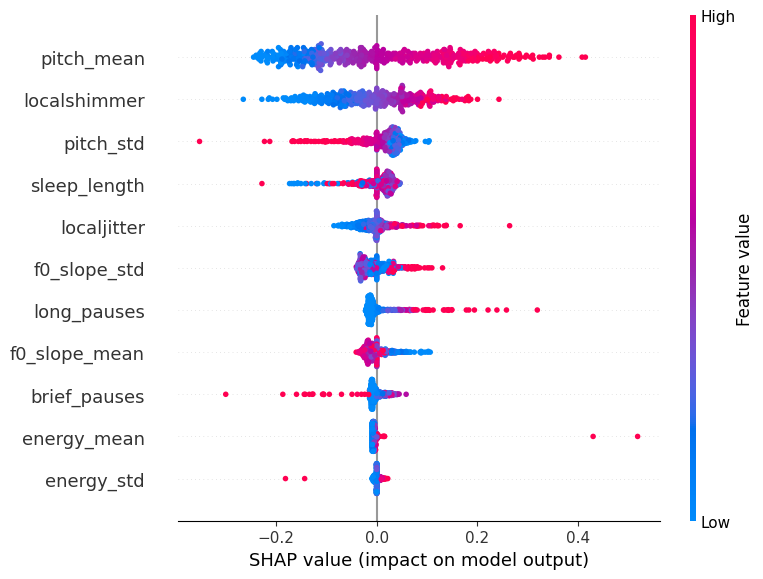

C:\Users\XXX\AppData\Local\Temp\ipykernel_2588\1214242901.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


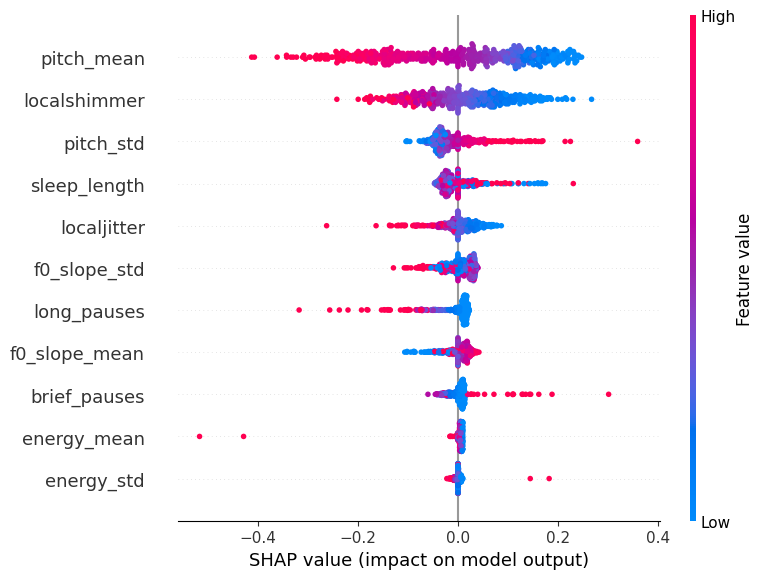

C:\Users\XXX\AppData\Local\Temp\ipykernel_2588\1214242901.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


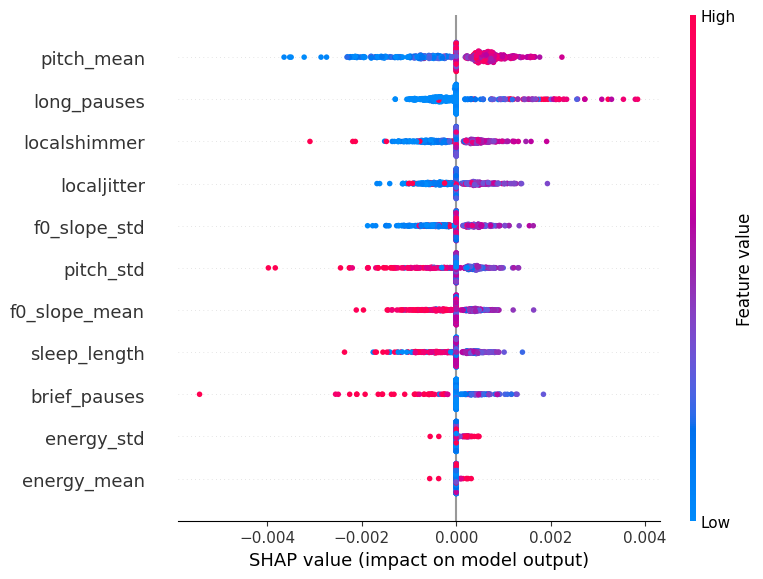

C:\Users\XXX\AppData\Local\Temp\ipykernel_2588\1214242901.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


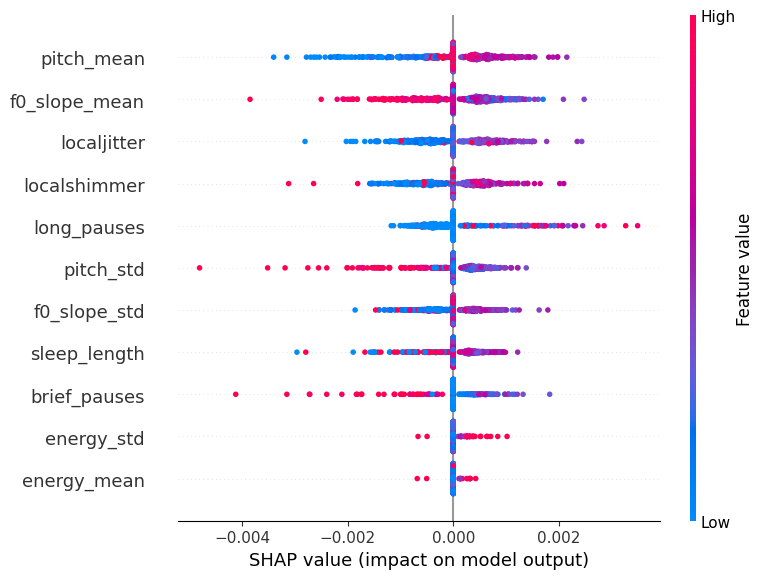

<Figure size 640x480 with 0 Axes>

In [45]:
# PLOTS
for class_id in range(shap_values.shape[2]):
    shap.summary_plot(
        shap_values[:, :, class_id],
        X_test,
        feature_names=feature_names,
        max_display=end,
        show=True
    )
    plt.gcf()
    plt.clf()

# 3)

In [112]:
testset = pd.concat([X_test, y_test], axis = 1).reset_index(drop=True, inplace=False)

In [103]:
def membership_function_shap(data, var_name, value, central=0, spread=0.1, plot=True, na_omit=False,
           expert = False,use_central_and_spread=False):
    d = deepcopy(data)

    if na_omit:
        d = d.loc[~d[var_name].isna()]
    else:
        d = d.fillna(0)

    d = d[var_name]

    d_abs = d.abs()
    d_median = d_abs.median()

    max_for_universe = np.max(d)
    min_for_universe = np.min(d)

    # if np.isclose(min_for_universe, max_for_universe):
    #     # If all values are the same, treat as 'medium'
    #     if isinstance(value, pd.Series):
    #         low_membership = pd.Series(0.0, index=value.index)
    #         medium_membership = pd.Series(1.0, index=value.index)
    #         high_membership = pd.Series(0.0, index=value.index)
    #     else:
    #          low_membership = 0.0
    #          medium_membership = 1.0
    #          high_membership = 0.0

    #     return (low_membership, medium_membership, high_membership)

    universe = np.arange(min_for_universe, max_for_universe, 0.001)

    reg_name = var_name

    reg = ctrl.Consequent(universe, reg_name)

    # if use_central_and_spread:
    #     first_quartile = np.max([0,min_for_universe])
    #     median_quartile = 0.1
    #     third_quartile = np.min([0.2,max_for_universe])
    # else:
    #     first_quartile = np.percentile(d, 25)
    #     median_quartile = np.percentile(d, 50)
    #     third_quartile = np.percentile(d, 75)

    low = fuzz.trapmf(reg.universe, [min_for_universe, min_for_universe, -d_median, 0])
    medium = fuzz.trimf(reg.universe, [-d_median, 0, d_median])
    high = fuzz.trapmf(reg.universe, [0, d_median, max_for_universe, max_for_universe])

    if plot:
        fig, (ax0) = plt.subplots(nrows=1, figsize=(3, 3))
        ax0.plot(universe, low, 'b', linewidth=2, label='low')
        ax0.plot(universe, medium, 'r', linewidth=2, label='medium')
        ax0.plot(universe, high, 'g', linewidth=2, label='high')
        ax0.set_title(str(var_name))
        ax0.legend()
        plt.tight_layout()
        plt.savefig(f'{var_name}_shap.png')
        plt.close()

    return (fuzz.interp_membership(universe, low, value),
            fuzz.interp_membership(universe, medium, value),
            fuzz.interp_membership(universe, high, value)
            )

## Function to generate predictive linguistic summaries

In [117]:
def generate_predictive_linguistic_summaries(dataframe, words1, qualifier_var, target_contribution, states, norms, model):

    dataframe = deepcopy(dataframe)
    
    y = dataframe['state']
    X = dataframe.drop('state', axis = 1)
    y_pred = model.predict(X)
    
    contributions = []
    for contribution in target_contribution:
        explainer = shap.Explainer(model, dataframe)
        shap_values = explainer(dataframe)
        shap_col = f'shap_{contribution}'
        dataframe[shap_col] = shap_values[:, contribution, 1].values
        contributions.append(shap_col)

    vars = []
    for var in qualifier_var:
        ling = membership_function(dataframe, var,dataframe.loc[0:,var], central=0, spread=0.1, plot=True, na_omit=False,
                  expert = False,use_central_and_spread=False)

        ling_df = pd.DataFrame({f'low {var}': ling[0], f'medium {var}': ling[1], f'high {var}': ling[2]})

        ling_df.reset_index(drop=True, inplace=True)
        dataframe = pd.concat([dataframe, ling_df], axis=1)
        vars.append(f'low {var}')
        vars.append(f'medium {var}')
        vars.append(f'high {var}')

    contrib_vars = []
    for var in contributions:
        ling = membership_function_shap(dataframe, var,dataframe.loc[0:,var], central=0, spread=0.1, plot=True, na_omit=False,
                  expert = False,use_central_and_spread=False)

        ling_df = pd.DataFrame({f'strongly negative {var}': ling[0], f'around zero {var}': ling[1], f'strongly positive {var}': ling[2]})

        ling_df.reset_index(drop=True, inplace=True)
        dataframe = pd.concat([dataframe, ling_df], axis=1)
        contrib_vars.append(f'strongly negative {var}')
        contrib_vars.append(f'around zero {var}')
        contrib_vars.append(f'strongly positive {var}')

    y_pred_series = pd.Series(y_pred[:,1], index=y.index)
    tp_mask = (y == 1) & (y_pred_series == 1)
    tn_mask = (y == 0) & (y_pred_series == 0)
    dataframe = dataframe[tp_mask | tn_mask]

    combinations = list(product(vars, states, contrib_vars, words1, norms))

    output = []
    for combination in combinations:
        var, state, contrib_var, word, norm = combination

        d = deepcopy(dataframe)

        result_df = pd.DataFrame(columns=['Descr', 'Degree of Truth'])
        if word == 'almost every':
            word1 = words('almost every')
        elif word == 'most':
            word1 = words('most')
        elif word == 'around half':
            word1 = words('around half')
        elif word == 'few':
            word1 = words('few')
        elif word == 'almost none':
            word1 = words('almost none')

        if state != 'all':
            d = d[d['state'] == state]

        if norm == 'min':
            mins = pd.concat([d[var], d[contrib_var]], axis=1).min(axis=1)
        elif norm == 'product':
            mins = pd.concat([d[var], d[contrib_var]], axis=1).apply(np.prod, axis=1)
        elif norm == 't_norm':
            mins = pd.concat([d[var], d[contrib_var]], axis=1).apply(lambda row: np.fmin(row[var], row[contrib_var]), axis=1)

        degree_of_truth = membership(word1, (np.sum(mins)) / (np.sum(d[var])), d[var])
        degree_of_support =   sum(mins>0) /len(d[var])
        degree_of_focus = sum(d[contrib_var]) / len(d[contrib_var])

        if state=='all':
          #tresc = f"For {word} records in test set with {var}, contribution of {contrib_var.join(contrib_var.split()[2:]).replace('shap_', '')} is {contrib_var.join(contrib_var.split()[:2])}"
            tresc = f"For {word} records in test set with {var}, contribution of {' '.join(contrib_var.split()[2:]).replace('shap_', '')} is {' '.join(contrib_var.split()[:2])}"
        elif state==0:
          #tresc = f"For {word} records in test set in euthymia with {var}, contribution of {contrib_var.join(contrib_var.split()[2:]).replace('shap_', '')} is {contrib_var.join(contrib_var.split()[:2])}"
            tresc = f"For {word} records in test set in euthymia with {var}, contribution of {' '.join(contrib_var.split()[2:]).replace('shap_', '')} is {' '.join(contrib_var.split()[:2])}"
        elif state==1:
          #tresc = f"For {word} records in test set in depression with {var}, contribution of {contrib_var.join(contrib_var.split()[2:]).replace('shap_', '')} is {contrib_var.join(contrib_var.split()[:2])}"
            tresc = f"For {word} records in test set in depression with {var}, contribution of {' '.join(contrib_var.split()[2:]).replace('shap_', '')} is {' '.join(contrib_var.split()[:2])}"

        result_df = pd.concat([result_df, pd.DataFrame({'Descr': [tresc],
                                      'Degree of Truth': [degree_of_truth]})])

        output.append(result_df)

    result_ls = pd.concat(output, ignore_index=True)

    return result_ls

## Generations of summaries

In [118]:
results_ls3 = generate_predictive_linguistic_summaries(testset, words1, variables, variables, states, norm, xgb_model.best_estimator_)

100%|===================| 1900/1906 [01:26<00:00]        C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\810832971.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Descr': [tresc],
C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\810832971.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Descr': [tresc],
C:\Users\XXX\AppData\Local\Temp\ipykernel_11304\810832971.py:92: FutureWarning: The behav

In [119]:
results_ls3

Descr  Degree of Truth
0     For almost every records in test set in euthym...         0.000000
1     For most records in test set in euthymia with ...         0.142190
2     For around half records in test set in euthymi...         1.000000
3     For few records in test set in euthymia with l...         0.000000
4     For almost none records in test set in euthymi...         0.000000
...                                                 ...              ...
3370  For almost every records in test set with high...         0.000000
3371  For most records in test set with high pitch_m...         0.000000
3372  For around half records in test set with high ...         0.000000
3373  For few records in test set with high pitch_me...         0.944309
3374  For almost none records in test set with high ...         0.240515

[3375 rows x 2 columns]

# 4)

In [120]:
all_summaries = pd.concat([results_ls2, results_ls3])

In [121]:
all_summaries.to_csv('all_summaries.csv', index=False)